In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/Pickleapp/20231129')

In [ ]:
X_train = np.load("train_X.npy")
y_train = np.load("train_y.npy")
X_test = np.load("test_X.npy")
y_test = np.load("test_y.npy")
X_test_noaug = np.load("noaug_test_X.npy")
y_test_noaug = np.load("noaug_test_y.npy")
right_X_train = np.load("right_orient_train_X.npy")
right_y_train = np.load("right_orient_train_y.npy")
right_X_test = np.load("right_orient_test_X.npy")
right_y_test = np.load("right_orient_test_y.npy")


In [ ]:
shape = (270, 480, 3)
points = [1,2,3,4,5,6]
point_cols = [(2 * (p-1), 2 * (p-1) + 1) for p in points]
point_cols = np.array(point_cols).flatten()
num_points = len(points) * 2

y_train = y_train[:, point_cols]
y_test = y_test[:, point_cols]
y_test_noaug = y_test_noaug[:, point_cols]
right_y_train = right_y_train[:, point_cols]
right_y_test = right_y_test[:, point_cols]


In [ ]:
bm = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
)
bm.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=shape)
x = bm(inputs, training=False)
# x.trainable = False
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_points, activation = 'relu')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten (Flatten)           (None, 276480)            0         
                                                                 
 dropout (Dropout)           (None, 276480)            0         
                                                                 
 dense (Dense)               (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 3317772 (12.66 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
def average_distance_loss(y_true, y_pred):
    """
    Custom loss function to calculate the average distance between predicted and target coordinates for 6 points.

    Parameters:
    - y_true: Tensor of shape (batch_size, 12), representing the target coordinates.
    - y_pred: Tensor of shape (batch_size, 12), representing the predicted coordinates.

    Returns:
    - loss: Tensor representing the average distance loss.
    """
    # Reshape the tensors to (batch_size, 6, 2) for easy indexing of coordinates
    # print(y_true)
    # print(y_pred)
    y_true = tf.reshape(y_true, (-1, 6, 2))
    y_pred = tf.reshape(y_pred, (-1, 6, 2))

    # Calculate Euclidean distance between each pair of coordinates
    distances = tf.norm(y_true - y_pred, axis=-1)
    # print(distances)
    # Calculate the average distance across all coordinates and batches
    loss = tf.reduce_mean(distances)

    return loss

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=average_distance_loss,
                metrics=['mae'])

In [ ]:
print(len(right_X_train), len(right_X_test))

714 186


In [ ]:
callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=400, restore_best_weights = True)
np.random.seed(42)
model.fit(right_X_train, right_y_train, epochs = 400, batch_size = 32, validation_data=(right_X_test, right_y_test), callbacks = [callback])

Epoch 1/400
23/23 [==============================] - 29s 564ms/step - loss: 419.5766 - mae: 257.9677 - val_loss: 253.5478 - val_mae: 148.3675
Epoch 2/400
23/23 [==============================] - 6s 273ms/step - loss: 180.0794 - mae: 110.5349 - val_loss: 92.3561 - val_mae: 58.7687
Epoch 3/400
23/23 [==============================] - 6s 277ms/step - loss: 119.5152 - mae: 76.0118 - val_loss: 70.0967 - val_mae: 44.6640
Epoch 4/400
23/23 [==============================] - 6s 279ms/step - loss: 119.1242 - mae: 75.9552 - val_loss: 55.7546 - val_mae: 35.6110
Epoch 5/400
23/23 [==============================] - 8s 333ms/step - loss: 107.1678 - mae: 68.2524 - val_loss: 63.7849 - val_mae: 40.8589
Epoch 6/400
23/23 [==============================] - 8s 342ms/step - loss: 111.7559 - mae: 71.2546 - val_loss: 87.5141 - val_mae: 55.8320
Epoch 7/400
23/23 [==============================] - 6s 272ms/step - loss: 112.6609 - mae: 71.7246 - val_loss: 59.0616 - val_mae: 37.8193
Epoch 8/400
23/23 [==========

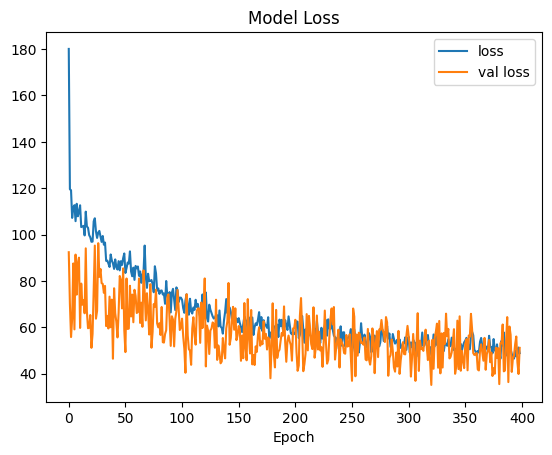

In [ ]:
# plot the history of the loss
start = 1
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss[start:], label="loss")
plt.plot(val_loss[start:], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()


In [ ]:
# test
model.evaluate(right_X_test, right_y_test)

6/6 [==============================] - 1s 207ms/step - loss: 51.0802 - mae: 33.0258


[51.08024597167969, 33.02577590942383]

In [ ]:
# training
model.evaluate(right_X_train, right_y_train)

23/23 [==============================] - 5s 207ms/step - loss: 50.1699 - mae: 32.4499


[50.16986083984375, 32.449851989746094]

In [ ]:
# unaugmented all test data
model.evaluate(X_test_noaug, y_test_noaug)

4/4 [==============================] - 3s 972ms/step - loss: 328.3444 - mae: 179.7665


[328.3443603515625, 179.76654052734375]

In [ ]:
bm.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten (Flatten)           (None, 276480)            0         
                                                                 
 dropout (Dropout)           (None, 276480)            0         
                                                                 
 dense (Dense)               (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 26837132 (102.38 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
# save weights
from google.colab import files
filename = 'ResNet50v2_right.h5'
model.save_weights(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>